Mean-reverting Bollinger Band Strategy. For each obs. model suggests a side but not size of the bet.

Initial setup

In [2]:
import sys
import platform
import src.data.reader as rd
from pathlib import PurePath
from multiprocessing import cpu_count
from src.utils.utils import *

print('Python %s on %s' % (sys.version, sys.platform))

pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'
file_name = 'IVE_tickbidask'

Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


Load the data

In [3]:
# Load from parquet
parq_file_name = file_name + '.parq'
infp = PurePath(data_raw_dir / parq_file_name)
df = pd.read_parquet(infp)

/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Clean and resample data

In [4]:
import src.features.datacleaner as dc

data_cleaner = dc.DataCleaner()

df = data_cleaner.remove_outliers(df, 'price')
df = df.resample('1T').median().drop_duplicates().dropna()



Generate features

Generate dollar bar based features

  0%|          | 0/564513 [00:00<?, ?it/s]

 29%|██▉       | 162847/564513 [00:00<00:00, 1628456.02it/s]

 59%|█████▉    | 333980/564513 [00:00<00:00, 1652462.31it/s]

 91%|█████████ | 512176/564513 [00:00<00:00, 1689287.18it/s]

100%|██████████| 564513/564513 [00:00<00:00, 1693389.21it/s]


  0%|          | 0/17512 [00:00<?, ?it/s]

  3%|▎         | 598/17512 [00:00<00:02, 5979.09it/s]

  7%|▋         | 1221/17512 [00:00<00:02, 6050.38it/s]

 11%|█▏        | 1981/17512 [00:00<00:02, 6444.33it/s]

 16%|█▌        | 2736/17512 [00:00<00:02, 6738.63it/s]

 20%|██        | 3525/17512 [00:00<00:01, 7046.61it/s]

 25%|██▍       | 4324/17512 [00:00<00:01, 7304.07it/s]

 29%|██▉       | 5072/17512 [00:00<00:01, 7355.19it/s]

 33%|███▎      | 5848/17512 [00:00<00:01, 7471.33it/s]

 38%|███▊      | 6626/17512 [00:00<00:01, 7559.11it/s]

 42%|████▏     | 7405/17512 [00:01<00:01, 7624.91it/s]

 47%|████▋     | 8203/17512 [00:01<00:01, 7726.16it/s]

 51%|█████▏    | 8981/17512 [00:01<00:01, 7742.14it/s]

 56%|█████▌    | 9770/17512 [00:01<00:00, 7784.95it/s]

 60%|██████    | 10544/17512 [00:01<00:00, 7766.08it/s]

 65%|██████▍   | 11337/17512 [00:01<00:00, 7812.14it/s]

 69%|██████▉   | 12127/17512 [00:01<00:00, 7835.59it/s]

 74%|███████▎  | 12912/17512 [00:01<00:00, 7838.42it/s]

 78%|███████▊  | 13706/17512 [00:01<00:00, 7866.73it/s]

 83%|████████▎ | 14492/17512 [00:01<00:00, 7853.77it/s]

 87%|████████▋ | 15289/17512 [00:02<00:00, 7886.62it/s]

 92%|█████████▏| 16078/17512 [00:02<00:00, 7886.09it/s]

 96%|█████████▋| 16867/17512 [00:02<00:00, 7855.09it/s]

100%|██████████| 17512/17512 [00:02<00:00, 7655.93it/s]

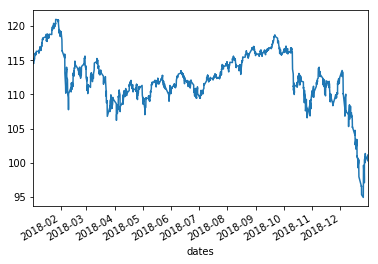

In [5]:
import src.features.bars as bar
import src.features.labeller as lab

bars = bar.Bars()
dbars = bars.dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()

close = dbars.price.copy()
labeller = lab.Labeller()
dailyVol = labeller.getDailyVol(close).dropna()

tEvents = labeller.getTEvents(close, h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close, numDays=1)

close.loc['2018'].plot()

Create meta labels (side of trade buy/sell).

In [6]:
import src.features.indicators.bollinger_band as bb
window = 20
numsd = 1
bband = bb.BollingerBand()


bb_side_raw = bband.get_side(close, window=window, numsd=numsd)


cprint(bb_side_raw)


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
dates                 
2019-02-19 11:42:00 -1
2019-02-20 10:59:00 -1
2019-02-21 11:12:00  1
2019-02-21 13:51:00  1
2019-02-22 12:07:00 -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1907 entries, 2009-10-06 10:16:00 to 2019-02-22 12:07:00
Data columns (total 1 columns):
0    1907 non-null int64
dtypes: int64(1)
memory usage: 29.8 KB
None
-------------------------------------------------------------------------------



-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         price      ave    upper    lower
dates                                                    
2019-02-22 13:34:00  112.94600  112.788  112.985  112.590
2019-02-22 13:51:00  112.91035  112.773  112.949  112.597
2019-02-22 14:35:00  112.82990  112.770  112.945  112.596
2019-02-22 15:25:00  112.86175  112.773  112.948  112.597
2019-02-22 15:39:00  112.84000  112.779  112.955  112.604
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17514 entries, 2009-09-28 10:44:00 to 2019-02-22 15:39:00
Data columns (total 4 columns):
price    17514 non-null float64
ave      17495 non-null float64
upper    17495 non-null float64
lower    17495 non-null float64
dtypes: float64(4)
memory usage: 684.1 KB
None
-------------------------------------------

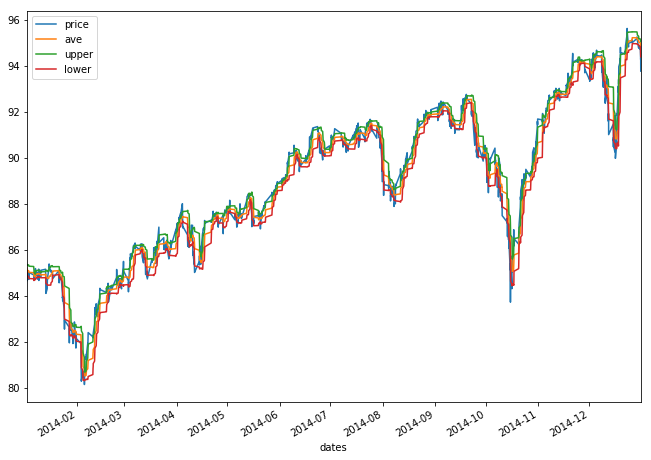

In [7]:
f,ax=plt.subplots(figsize=(11,8))
bb_df = pd.DataFrame()
bb_df['price'], bb_df['ave'], bb_df['upper'], bb_df['lower'] = bband.bbands(close, window=window, width=None, numsd=numsd)
cprint(bb_df)
bb_df.dropna(inplace=True)
bb_df.loc['2014'].plot(ax=ax)

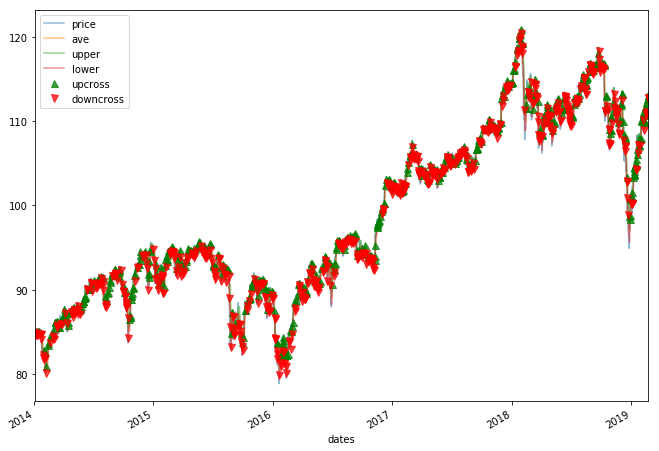

In [8]:
f, ax = plt.subplots(figsize=(11,8))

bb_up = bband.get_up_cross(bb_df, 'price')
bb_down = bband.get_down_cross(bb_df, 'price')

bb_df.loc['2014':].plot(ax=ax, alpha=.5)
bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()

In [9]:
minRet = .01 
ptsl=[0,2]
target = dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

bb_events = labeller.getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
cprint(bb_events)

bb_side = bb_events.dropna().side
cprint(bb_side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     side                  t1      trgt
2019-01-10 15:03:00  -1.0 2019-01-11 15:13:00  0.010971
2019-01-22 15:17:00   NaN 2019-01-23 15:44:00  0.011435
2019-01-23 09:58:00   NaN 2019-01-24 10:25:00  0.011693
2019-01-23 11:57:00   1.0 2019-01-24 12:17:00  0.011364
2019-01-24 10:25:00  -1.0 2019-01-25 10:44:00  0.010447
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2009-10-02 10:49:00 to 2019-01-24 10:25:00
Data columns (total 3 columns):
side    180 non-null float64
t1      746 non-null datetime64[ns]
trgt    746 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.3 KB
None
-------------------------------------------------------------------------------

--------------------------------------------------

2019-03-24 19:32:45.437373 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes.


In [10]:
bb_side.value_counts()

-1.0    95
 1.0    85
Name: side, dtype: int64

In [11]:
bb_bins = labeller.getBins(bb_events, close).dropna()
print(bb_bins.bin.value_counts())

1.0    92
0.0    88
Name: bin, dtype: int64
